# $\text{The Ishigami Function}$
## Scalar-Output

In [ ]:
from utils import *

#### Define parameters

In [ ]:
N_set = [100,1000,10000,100000]
num_of_experiments_per_N = 50
model_save_directory = 'data/ishigami/pick_freeze'
model_save_name = f'N_set_{N_set}__numOfExperiments_{num_of_experiments_per_N}'.replace("[","").replace("]","").replace(",","_").replace(" ","")
print(model_save_name)

#### Create a new model

In [ ]:
ishigami = model(model_type="ishigami", vectSize=3, model_save_directory=model_save_directory)

#### Load an existing model (and data)

In [ ]:
ishigami = load_model(load_dir=f'{model_save_directory}/{model_save_name}.pkl')

#### Run the Pick-Freeze estimation for the ishigami function's main-effect Sobol' indices

In [ ]:
run_sobols(model=ishigami, N_set=N_set, itersPerN=num_of_experiments_per_N)

#### Save the model and data if desired

In [ ]:
ishigami.save_model(file_name=model_save_name)

#### Plot the results

In [ ]:
plotter.plot(model=ishigami,
            multi_experiment=True,
            withOutliers=False,
            withTrend=True,
            no_title=True,
            not_differences=False,
            only_singulars=True,
            base_fontsize=20,
            save_fig=True,
            save_directory='figs/ishigami/pick_freeze/scalar',
            fig_name=f'ishigami_pickFreeze_convergence_{model_save_name}.pdf')

# $\text{The Ishigami Function}$
## Vectorized-Set-Output

#### Imports

In [ ]:
from utils import numeric_models as nm
from utils import plotter, solvers
from utils.other_utils import gen_uniform_1d_mesh_from_interval_and_resolution as genUniMesh
from utils.other_utils import load_model, save_model, getSingletonIndexAsInt
from glob import glob, escape
import time
import numpy as np
from os import makedirs
import pandas as pd
import matplotlib.pyplot as plt

### Calculating aggr' sobols by calculating weights individually

#### Setup

In [ ]:
# interval_domain = [-np.pi, -2.0]
interval_domain = [-np.pi, np.pi]
interval_mesh_resolution = 8
ishigami_indicator_constraint_val = 3
x3_as_mesh = genUniMesh(domain=interval_domain, mesh_resolution=interval_mesh_resolution)
expNum_set = [1000]
N_set = [1000]
N_min = np.min(N_set)
N_max = np.max(N_set)
save_dir = 'data/ishigami/indicator/scalar/mesh_x3_'
save_dir += f'{list(np.round(interval_domain, 2))}'.replace("np.float64(", "").replace(")", "").replace('.','_').replace(' ', '').replace('-','neg').replace('[','<').replace(']','>')
save_dir += f'_h_{interval_mesh_resolution}_constraint_{ishigami_indicator_constraint_val}'
print(save_dir)
makedirs(save_dir, exist_ok=True)
ishi_models_list = []

#### Run

In [ ]:
for x_3 in x3_as_mesh:
    t0 = time.time()
    ishigami = nm.model(model_type='ishigami', vectSize=2)  
    ishigami.specifyX3 = True
    ishigami.x_3 = x_3
    ishigami.ishigami_indicator = True
    ishigami.constraintVal = ishigami_indicator_constraint_val
    for _ in range(expNum_set[0]):
        solvers.run_sobols(model=ishigami, N_set=N_set)
    ishi_models_list.append(ishigami)
    save_name = f"x3_{np.round(x_3,2)}".replace('.', '_').replace('-', 'neg')
    save_model(model=ishigami, save_dir=save_dir, save_name=save_name)
    t1 = time.time()
    print(f"Done for x_3: {x_3:0.2f} | T: {t1-t0:0.3f}s")

#### Load data (if not run)

In [ ]:
ishi_models_list = []
files = glob(f"{save_dir}/*.pkl")

for file in files:
    print(file)
    ishi_models_list.append(load_model(load_dir=file))

#### Calculate $S^{\text{clos},Y}_A$ (Aggregate sobol indices)

In [ ]:
V_hat_list_all_exps = []
for experim_i_key in range(expNum_set[0]):
    V_hat_list_all_exps.append([np.mean([ishi_models_list[x3_idx].exprimentDataDict[0][experim_i_key]['indiv_output_variance'][f"{N_set[-1]}"]]) for x3_idx in range(len(ishi_models_list))])
V_hat_list_all_exps = np.array(V_hat_list_all_exps)
sum_all_v_hat_all_exps = np.sum(V_hat_list_all_exps,axis=1)
c_j_list_all_exps = V_hat_list_all_exps / sum_all_v_hat_all_exps[:, None]

In [ ]:
first_order_indices = ['01', '10']
sobolVals_clos_aggr_adjusted = {k: [] for k in first_order_indices}
num_of_experiments = len(ishi_models_list[0].exprimentDataDict[0])
N_set = ishi_models_list[0].N_set       
N_final = f"{N_set[-1]}" # can adjust so we can do for multiple N instead of just the N_final                              
num_of_mesh_nodes = len(ishi_models_list)
for sob_idx_str in first_order_indices:
    # for each sample i, compute the weighted sum across models
    for i in range(num_of_experiments):
        weighted_sum = 0.0
        for model_idx in range(num_of_mesh_nodes):
            val = ishi_models_list[model_idx].exprimentDataDict[0][i]['sobolVals_clos'][N_final][sob_idx_str]
            weighted_sum += val * c_j_list_all_exps[model_idx]
        sobolVals_clos_aggr_adjusted[sob_idx_str].append(weighted_sum)
values = np.array([np.asarray(sobolVals_clos_aggr_adjusted['01']).reshape(-1), np.asarray(sobolVals_clos_aggr_adjusted['10']).reshape(-1)])

#### Plot individually calculated Aggr Sobol' Results

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from os import path, makedirs
import re

def plot_indiv_calculated_S_aggr(values,
                                N_set,
                                base_fontsize=20,
                                save_fig=False,
                                save_directory='',
                                fig_name=''):
    fig, axes = plt.subplots(1, 2, figsize=(20, 8), sharey=True)
    plt.rcParams['font.family'] = 'STIXGeneral'
    colors = ["tomato", "royalblue"]
    base_fontsize = base_fontsize

    for ax, val, color in zip(axes, values, colors):
        box = ax.boxplot(val, patch_artist=True, showfliers=False)
        ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
        for patch in box['boxes']:
            patch.set_facecolor(color)
            patch.set_edgecolor("black")
        for whisker in box['whiskers']:
            whisker.set_color(color)
        for cap in box['caps']:
            cap.set_color(color)
        for median in box['medians']:
            median.set_color("black")
        ax.set_xticks(range(1, len(N_set) + 1))         
        myXTicks = [rf"$10^{int(np.log10(x))}$" for x in N_set]
        ax.set_xticklabels(myXTicks)
        ax.tick_params(axis='x', labelsize=base_fontsize)
        ax.tick_params(axis='y', labelsize=base_fontsize)
        for label in ax.get_xticklabels():
            label.set_fontname('STIXGeneral')

    fig.supylabel(r"$\hat{S}^{aggr}_{A}$", fontsize=(base_fontsize+2))
    fig.supxlabel(r"Number of Samples, $N$", fontsize=(base_fontsize+2), y=0.02)
    box_handles = [mpatches.Patch(color=c, label=rf"$U_{i+1}$") for i, c in enumerate(colors)]
    if base_fontsize <= 11:
        vert_space_add_to_legend = 0.02
    else:
        vert_space_add_to_legend = (base_fontsize-14)/100
    fig.legend(handles=box_handles,
                loc="upper center",
                ncol=len(colors) + 1,
                bbox_to_anchor=(0.5, 1.00+vert_space_add_to_legend),
                fontsize=(base_fontsize+1),
                frameon=False) 
    fig.tight_layout(rect=[0.01, 0, 1, 0.97])
    if save_fig:
        if save_directory == '':
            save_directory = model.figsave_directory
        else:
            if not path.exists(save_directory):
                makedirs(save_directory)
        if fig_name == '':
            fig_name = 'ishigami_pickfreeze.pdf'
        plt.savefig(f"{save_directory}/{fig_name}", dpi=900, bbox_inches='tight')
    plt.show()

interval=re.search(r"<(.*?)>", files[0]).group(1)
save_directory = 'figs/ishigami/pick_freeze/mesh/scalar'
fig_name = f'ishigami_scalared_mesh_h_{len(files)-1}_interval_{interval}_Nexp_{num_of_experiments}_Nset_{N_set}.pdf'.replace(',', '_').replace('[','').replace(']','').replace(' ', '')
print(fig_name)
plot_indiv_calculated_S_aggr(values=values, 
                            N_set=N_set, 
                            base_fontsize=20,
                            save_fig=True,
                            save_directory=save_directory,
                            fig_name=fig_name)

#### Plot Aggr Sobols' Results

In [ ]:
import matplotlib.pyplot as plt

x_axis_keys = list(sobolVals_clos_aggr_adjusted_.keys())
y_axis_values = list(sobolVals_clos_aggr_adjusted_.values())
x_tick_pos = np.arange(len(x_axis_keys))
plt.scatter(x_tick_pos, y_axis_values, color="blue", s=80)
plt.xticks(x_tick_pos, x_axis_keys)
plt.xlabel("Input indices")
plt.ylabel(r"$S^{aggr}_A$")
interval_as_str = f'{list(np.round(interval_domain, 2))}'.replace("np.float64(", "").replace(")", "")
plt.title(r"Aggr. Sobols for Ishigami on interval $x_3\in$" + f"{interval_as_str}")

plt.show()

#### Plot Individual Sobols' Results

In [ ]:
for model in ishi_models_list:
    plotter.plot(model=model,
            multi_experiment=True,
            withOutliers=False,
            withTrend=False,
            not_differences=True,
            only_singulars=True,
            save_fig=False)
            # save_directory=f'kbsa/sobol_indicator_figs',
            # fig_name=f'sobol_boxplots_x3_{x3}_N_[1e{int(np.log10(N_min))}:1e{int(np.log10(N_max))}]__indicator__NoOutliers__onlySingulars.pdf')

### Calculating aggr' sobols via trace

In [ ]:
from utils import numeric_models as nm
from utils import plotter, solvers
from utils.other_utils import gen_uniform_1d_mesh_from_interval_and_resolution as genUniMesh
from utils.other_utils import load_model, save_model, getSingletonIndexAsInt
from glob import glob, escape
import time
import numpy as np
from os import makedirs
import matplotlib.pyplot as plt

#### Setup

In [ ]:
interval_domain = [-np.pi, np.pi]
interval_mesh_resolution = 8
ishigami_indicator_constraint_val = 3
expNum_set = [50]
N_set = [100,1000,10000,100000]
N_min = np.min(N_set)
N_max = np.max(N_set)
save_dir = 'data/ishigami/indicator/vector/'
save_dir += f'{list(np.round(interval_domain,2))}_expNum_{expNum_set}_Nset_{N_set}'.replace("np.float64(", "").replace(")", "").replace('.','_').replace(' ', '').replace('-','neg').replace('[','<').replace(']','>')
save_dir += f'_h_{interval_mesh_resolution}_constraint_{ishigami_indicator_constraint_val}'
makedirs(save_dir, exist_ok=True)
ishi_vect_models_list = []

#### Run

In [ ]:
t0 = time.time()
ishigami_vect = nm.model(model_type='ishigami_vect', vectSize=2)
ishigami_vect.ishigami_indicator = True
ishigami_vect.constraintVal = ishigami_indicator_constraint_val
ishigami_vect.meshInterval = interval_mesh_resolution
ishigami_vect.set_uniform_1D_mesh(interval=interval_domain)

for _ in range(expNum_set[0]):
    solvers.run_sobols(model=ishigami_vect, N_set=N_set, x_interval_of_interest=interval_domain)
ishi_vect_models_list.append(ishigami_vect)
save_name = "ishigami_vect_model"
save_model(model=ishigami_vect, save_dir=save_dir, save_name=save_name)
t1 = time.time()
print(f"Done | t: {t1-t0:0.3f} (s)")

#### Load data 

In [ ]:
from glob import glob
from utils import plotter
from utils.other_utils import load_model

In [ ]:
ishi_vect_models_list = []
files = glob("data/ishigami/indicator/vector/**/*.pkl")
for file in files:
    if 'Nset' not in file:
        continue
    if '100000' not in file:
        continue
    print(file)
    ishi_vect_models_list.append(load_model(load_dir=file))
ishi_vect_models_list

In [ ]:
ishi_vect_models_list[1].ishi_interval = [-np.pi, -1.0]
ishi_vect_models_list[2].ishi_interval = [-np.pi, np.pi]

#### Plot

In [ ]:
save_directory = 'figs/ishigami/pick_freeze/mesh/trace'
for model in ishi_vect_models_list:
    interval_domain = model.ishi_interval
    interval_domain_trimmed = [round(x, 2) for x in interval_domain]
    N_set = model.N_set
    num_of_experiments = len(model.exprimentDataDict[str(interval_domain).replace(" ", "")])
    mesh_resolution = model.meshInterval
    fig_name = f'ishigami_traced_mesh_h_{mesh_resolution}_interval_{interval_domain_trimmed}_Nexp_{num_of_experiments}_Nset_{N_set}'.replace(',', '_').replace('[','').replace(']','').replace(' ', '').replace('.','_').replace('-','neg') + '.pdf'
    print(fig_name)
    plotter.plot(model=model,
                    N_set=N_set,
                    plot_type='sobols',
                    not_differences=True,
                    only_singulars=True,
                    interval_toggle=True,
                    multi_experiment=True,
                    which_interval=interval_domain, 
                    which_N=N_set[0],
                    base_fontsize=20,# $$3vfdADFA,
                    plot_which_sobols='closed_aggr',
                    no_title=True,
                    withTrend=True,
                    save_fig=True,
                    save_directory=save_directory,
                    fig_name=fig_name)

----------

# $\text{The 1D-Diffusion Problem}$
## Scalar-Output

In [ ]:
from utils import numeric_models as nm
from utils import solvers
import time
import numpy as np
from os import makedirs
from sys import stdout

In [ ]:
#these indices represent the h+1 many spatial-mesh-node-indices. Eg, index 1 translates to spatial point x=1/(h+1), and 32 to x=32/(h+1)
evaluate_at_x_idx_list = [1,32,64] 
interval_mesh_resolution = 128
diffuFen_sobol_vect_len = interval_mesh_resolution+1
P = 3
mu = 1
std = 5
indicator_constraint_val = 0.135
indicator_toggle = False
expNum_set = [20]
N_set = [100, 1000]

N_min = np.min(N_set)
N_max = np.max(N_set)
if indicator_toggle:
    save_dir = f'data/1d_diffusion/pick_freeze/indicator/scalar/h_{interval_mesh_resolution}_max_N_{N_set[-1]}/'
else:
    save_dir = f'data/1d_diffusion/pick_freeze/non-indicator/scalar/h_{interval_mesh_resolution}_max_N_{N_set[-1]}/'
print(save_dir)
makedirs(save_dir, exist_ok=True)
diffuFen_models_list = []

In [ ]:
for x_idx in evaluate_at_x_idx_list:
    save_name = f'1d_diffusion_xIdx_{x_idx}_xVal_{x_idx/129:.2f}_Nset_{N_set}'
    save_name = save_name.replace("np.int64(", "").replace("np.float64(", "").replace(")", "").replace('.','_').replace(' ', '').replace('-','neg').replace('[','<').replace(']','>')
    if indicator_toggle:
        save_name += f'_sobVectLen_{diffuFen_sobol_vect_len}_h_{interval_mesh_resolution}_constraint_{indicator_constraint_val}'
    else:
        save_name += f'_sobVectLen_{diffuFen_sobol_vect_len}_h_{interval_mesh_resolution}'
    

    t0 = time.time()
    diffusion_1d = nm.model(model_type='diffusion_1D_both',
                            P=P,
                            mean=mu,
                            std=std,
                            meshInterval=interval_mesh_resolution,
                            indicator_toggle=indicator_toggle,
                            indicator_constraint_val=indicator_constraint_val,
                            FEM_projection=False,
                            model_save_directory=save_dir,
                            model_save_name=save_name)
    t0_inner, t1_inner = 0, 0
    t0_outer = time.time()
    for curr_exp in range(expNum_set[0]):
        if curr_exp != 0:
            stdout.write(f'\r{save_name} | time_prev_experiment_#{curr_exp}: {t1_inner-t0_inner:0.3f} (s). Time so far: {t1_inner-t0_outer:0.3f} (s)')
            stdout.flush()
        t0_inner = time.time()
        solvers.run_sobols(model=diffusion_1d, N_set=N_set, scalarDiffuIdx=x_idx)
        t1_inner = time.time()
    diffuFen_models_list.append(diffusion_1d)
    print('\n')
    diffusion_1d.save_my_model()
    # save_model(model=diffusion_1d, save_dir=save_dir, save_name=save_name)
    t1 = time.time()
    print(f" -> {x_idx/129} done! Total time: {t1-t0:0.3f} (s).\n---------------------------------------")

In [ ]:
from glob import glob
from utils.other_utils import load_model

diffuFen_models_list = []
file_sup_dir = 'data/1d_diffusion/pick_freeze/non-indicator/scalar/h_128_max_N_1000'
files = glob(f"{file_sup_dir}/*.pkl")
for file in files:
    print(file)
    diffuFen_models_list.append(load_model(load_dir=file))
diffuFen_models_list

In [ ]:
from utils import plotter
import re
for file in files:
    model = load_model(load_dir=file)
# for model in diffuFen_models_list:
    file_name = file[len(file_sup_dir)+1:-4]
    print(file_name)
    which_index = list(model.exprimentDataDict.keys())[0]
    plotter.plot(model=model,
                N_set=model.N_set,
                only_singulars=True,
                withOutliers=False,
                withTrend=False,
                grid_toggle=True,
                base_fontsize=22,
                save_fig=True,
                which_interval = None,
                which_index = which_index,
                save_directory='figs/1d_diffusion/vbsa/scalar',
                fig_name=file_name)
                # save_directory='figs/toy_2/pick_freeze/traced',
                # fig_name=f'toy_2_convergence_{save_name}.pdf')

# $\text{The 1D-Diffusion Problem}$
## Vectorized-Set-Output

#### Imports

In [ ]:
from utils import numeric_models as nm
from utils import solvers
import time
import numpy as np
from os import makedirs
from sys import stdout

#### Setup

In [ ]:
# interval_domain_list = [[0.0,1.0],[0.3,0.7],[0.45,0.55],[0.6,1.0]]
# interval_domain_list = [[0.0,1.0],[0.45,0.55]]
interval_domain_list = [[0.0,0.4], [0.6,1.0]]
interval_mesh_resolution = 1024

#this is set equal to mesh_interval when model is initiated. One can change it to maintain a specific resolution to sample equally from
#if the projectOutputToCG option is chosen
projectOutputToCG = False
diffuFen_sobol_vect_len = interval_mesh_resolution+1
P = 3
mu = 1
std = 5
indicator_constraint_val = 0.135
indicator_toggle = True

expNum_set = [20]
N_set = [100,1000,10000]

N_min = np.min(N_set)
N_max = np.max(N_set)
save_dir = f'data/1d_diffusion/pick_freeze/indicator/vector/h_{interval_mesh_resolution}_max_N_{N_set[-1]}/'
if projectOutputToCG:
    save_dir += f"_projd_sobVectLec_{diffuFen_sobol_vect_len}"
print(save_dir)
makedirs(save_dir, exist_ok=True)
diffuFen_models_list = []

#### Run

In [ ]:
myT = (((2*20)+(14*20)+(155*20))*4)/(60*60)
f"{int(myT)}hr, {(myT-int(myT))*60:.0f}min"

In [ ]:
for interval_domain in interval_domain_list:
    save_name = f'1d_diffusion_{list(np.round(interval_domain,2))}_Nset_{N_set}'
    save_name = save_name.replace("np.int64(", "").replace("np.float64(", "").replace(")", "").replace('.','_').replace(' ', '').replace('-','neg').replace('[','<').replace(']','>')
    if not projectOutputToCG:
        save_name += f'_h_{interval_mesh_resolution}_constraint_{indicator_constraint_val}'
    else:
        save_name += f'_sobVectLen_{diffuFen_sobol_vect_len}_h_{interval_mesh_resolution}_constraint_{indicator_constraint_val}'

    t0 = time.time()
    diffusion_1d = nm.model(model_type='diffusion_1D_both',
                            P=P,
                            mean=mu,
                            std=std,
                            meshInterval=interval_mesh_resolution,
                            indicator_toggle=indicator_toggle,
                            indicator_constraint_val=indicator_constraint_val,
                            FEM_projection=projectOutputToCG,
                            model_save_directory=save_dir,
                            model_save_name=save_name)
    t0_inner, t1_inner = 0, 0
    t0_outer = time.time()
    for curr_exp in range(expNum_set[0]):
        if curr_exp != 0:
            stdout.write(f'\r{save_name} | time_prev_experiment_#{curr_exp}: {t1_inner-t0_inner:0.3f} (s). Time so far: {t1_inner-t0_outer:0.3f} (s)')
            stdout.flush()
        t0_inner = time.time()
        solvers.run_sobols(model=diffusion_1d, N_set=N_set, x_interval_of_interest=interval_domain)
        t1_inner = time.time()
    diffuFen_models_list.append(diffusion_1d)
    print('\n')
    diffusion_1d.save_my_model()
    # save_model(model=diffusion_1d, save_dir=save_dir, save_name=save_name)
    t1 = time.time()
    print(f" -> {interval_domain} done! Total time: {t1-t0:0.3f} (s).\n---------------------------------------")

#### Load data

In [ ]:
from glob import glob
from utils.other_utils import load_model

diffuFen_models_list = []
file_sup_dir = 'data/1d_diffusion/pick_freeze/indicator/vector/h_1024_max_N_10000'
files = glob(f"{file_sup_dir}/*.pkl")
for file in files:
    print(file)
    diffuFen_models_list.append(load_model(load_dir=file))
diffuFen_models_list

In [ ]:
from utils import plotter
import re
for file in files:
    model = load_model(load_dir=file)
# for model in diffuFen_models_list:
    if 10000 not in model.N_set:
        continue
    file_name = file[len(file_sup_dir)+1:-4]
    print(file_name)
    plotter.plot(model=model,
                N_set=model.N_set,
                only_singulars=True,
                withOutliers=False,
                withTrend=False,
                grid_toggle=True,
                base_fontsize=22,
                save_fig=True,
                save_directory='figs/1d_diffusion/vbsa/traced',
                fig_name=file_name)
                # save_directory='figs/toy_2/pick_freeze/traced',
                # fig_name=f'toy_2_convergence_{save_name}.pdf')

# $\text{Affine Linear Function}\;g_1$
## Vectorized-Set-Output

In [ ]:
from utils import numeric_models as nm
from utils import solvers
from utils.other_utils import save_model
import time
import numpy as np
from os import makedirs, path

In [ ]:
indicator_flag = True
indicator_constraint_val = 3.75
x_interval_domain = [0.25, 0.75]
x_interval_mesh_resolution = 128

expNum_set = [20]
N_set = [100, 1000, 10000]
# N_set = [10000]
N_min = np.min(N_set)
N_max = np.max(N_set)
if indicator_flag:
    save_dir = 'data/g_1/pick_freeze/indicator'
else:
    save_dir = 'data/g_1/pick_freeze/non_indicator'
makedirs(save_dir, exist_ok=True)
save_name = f"toy_1_model_file__exprimentNum_{expNum_set[0]}__Nset_{N_set}__xInterval_{x_interval_domain}__h_{x_interval_mesh_resolution}".replace("[", "").replace("]",'').replace(',', '_').replace(' ', '').replace('-','neg')
if indicator_flag:
    save_name += f"__constraintVal_{indicator_constraint_val}".replace('.', '_')

#### Run

In [ ]:
toy_1_models_list = []
t0 = time.time()
toy_1_vect = nm.model(model_type='toy_1_vect', vectSize=3)
toy_1_vect.indicator = indicator_flag
toy_1_vect.constraintVal = indicator_constraint_val
toy_1_vect.meshInterval = x_interval_mesh_resolution
toy_1_vect.set_uniform_1D_mesh(interval=x_interval_domain)

for _ in range(expNum_set[0]):
    solvers.run_sobols(model=toy_1_vect, N_set=N_set)
toy_1_models_list.append(toy_1_vect)

save_model(model=toy_1_vect, save_dir=save_dir, save_name=save_name)
t1 = time.time()
print(f"Done | T: {t1-t0:0.3f}s")

#### Load data from file

In [ ]:
from glob import glob
from utils.other_utils import load_model
toy_1_models_list = []
files = glob("data/g_1/pick_freeze/**/*.pkl")
for file in files:
    print(file)
    toy_1_models_list.append(load_model(load_dir=file))
toy_1_models_list

In [ ]:
from utils import plotter
for model in toy_1_models_list:
    plotter.plot(model=model,
                multi_experiment=True,
                withOutliers=False,
                withTrend=True,
                no_title=True,
                not_differences=True,
                only_singulars=True,
                base_fontsize=20,
                save_fig=True,
                only_aggr=True,
                toy_1_or_2=True,
                grid_toggle=True,
                save_directory='figs/g_1/pick_freeze/traced',
                fig_name=f'g_1_convergence_{save_name}.pdf')

# $\text{Affine Linear Function}\;g_2$ 
## Vectorized-Set-Output

In [ ]:
from utils import numeric_models as nm
from utils import plotter, solvers
from utils.other_utils import gen_uniform_1d_mesh_from_interval_and_resolution as genUniMesh
from utils.other_utils import load_model, save_model, getSingletonIndexAsInt
from glob import glob
import time
import numpy as np
from os import makedirs, path
import matplotlib.pyplot as plt

In [ ]:
indicator_flag = True
indicator_constraint_val = 5.25
x_interval_domain = [0.25, 0.75]
x_interval_mesh_resolution = 128

expNum_set = [20]
N_set = [100, 1000, 10000]
# N_set = [10000]
N_min = np.min(N_set)
N_max = np.max(N_set)
if indicator_flag:
    save_dir = 'data/g_2/pick_freeze/indicator'
else:
    save_dir = 'data/g_2/pick_freeze/non_indicator'
makedirs(save_dir, exist_ok=True)
save_name = f"g_2_model_file__exprimentNum_{expNum_set[0]}__Nset_{N_set}__xInterval_{x_interval_domain}__h_{x_interval_mesh_resolution}".replace("[", "").replace("]",'').replace(',', '_').replace(' ', '').replace('-','neg')
if indicator_flag:
    save_name += f"__constraintVal_{indicator_constraint_val}".replace('.', '_')

#### Run

In [ ]:
toy_2_models_list = []
t0 = time.time()
toy_2_vect = nm.model(model_type='toy_2_vect', vectSize=3)
toy_2_vect.indicator = indicator_flag
toy_2_vect.constraintVal = indicator_constraint_val
toy_2_vect.meshInterval = x_interval_mesh_resolution
toy_2_vect.set_uniform_1D_mesh(interval=x_interval_domain)

for _ in range(expNum_set[0]):
    solvers.run_sobols(model=toy_2_vect, N_set=N_set)
toy_2_models_list.append(toy_2_vect)
save_model(model=toy_2_vect, save_dir=save_dir, save_name=save_name)
t1 = time.time()
print(f"Done | T: {t1-t0:0.3f}s")

In [ ]:
toy_2_models_list = []
files = glob("data/g_2/pick_freeze/**/*.pkl")
for file in files:
    print(file)
    toy_2_models_list.append(load_model(load_dir=file))
toy_2_models_list

In [ ]:
for model in toy_2_models_list:
    plotter.plot(model=model,
                multi_experiment=True,
                withOutliers=False,
                withTrend=True,
                no_title=True,
                not_differences=True,
                only_singulars=True,
                base_fontsize=20,
                save_fig=True,
                only_aggr=True,
                toy_1_or_2=True,
                grid_toggle=True,
                save_directory='figs/g_2/pick_freeze/traced',
                fig_name=f'g_2_convergence_{save_name}.pdf')

# $\text{Nonlinear Problem}\;g_3$
## Vectorized-Set-Output

### $\;\mathbf{y} = (\mathbb{1}_{\{y_1\leq 0\}},...,\mathbb{1}_{\{y_{h+1}\leq 0\}})^T$,
### $y_i=G(X,U)=u_1+u_1u_2+x^{(i)}_hu_1$, 
### $\quad u_i\sim \mathbb{U}[ -1,1],\; i\in\{1,2\}$, 
### $\quad x\in[ -1,1] \rightarrow x_h\in\{-1,-1+\frac{1-(-1)}{h},...,1\}\;\;h\in\mathbb{N}_{>0}$.

#### Imports

In [ ]:
from utils import numeric_models as nm
from utils import plotter, solvers
from utils.other_utils import load_model, save_model
from glob import glob
import time
import numpy as np
from os import makedirs, path

### Calculating aggr' sobols via trace

#### Setup

In [ ]:
# interval_domain = [-np.pi, -2.0]
# interval_mesh_resolution = 8
# ishigami_indicator_constraint_val = 3
indicator_flag = True
indicator_constraint_val = 0.0
x_interval_domain = [-1.0, 1.0]
x_interval_mesh_resolution = 128

expNum_set = [20]
N_set = [100, 1000, 10000]
# N_set = [10000]
N_min = np.min(N_set)
N_max = np.max(N_set)
if indicator_flag:
    save_dir = 'data/g_3/pick_freeze/indicator'
else:
    save_dir = 'data/g_3/pick_freeze/non_indicator'
# save_dir += f'{list(np.round(interval_domain,2))}'.replace("np.float64(", "").replace(")", "").replace('.','_').replace(' ', '').replace('-','neg').replace('[','<').replace(']','>')
# save_dir += f'_h_{interval_mesh_resolution}_constraint_{ishigami_indicator_constraint_val}'
makedirs(save_dir, exist_ok=True)
toy_model_vect_models_list = []
save_name = f"g_3_model_file__exprimentNum_{expNum_set[0]}__Nset_{N_set}__xInterval_{x_interval_domain}__h_{x_interval_mesh_resolution}".replace("[", "").replace("]",'').replace(',', '_').replace(' ', '').replace('-','neg')
if indicator_flag:
    save_name += f"__constraintVal_{indicator_constraint_val}".replace('.', '_')

#### Run

In [ ]:
t0 = time.time()
toy_model_vect = nm.model(model_type='toy_model_vect', vectSize=2)
toy_model_vect.indicator = indicator_flag
toy_model_vect.constraintVal = indicator_constraint_val
toy_model_vect.meshInterval = x_interval_mesh_resolution
toy_model_vect.set_uniform_1D_mesh(interval=x_interval_domain)

for _ in range(expNum_set[0]):
    solvers.run_sobols(model=toy_model_vect, N_set=N_set)
toy_model_vect_models_list.append(toy_model_vect)


save_model(model=toy_model_vect, save_dir=save_dir, save_name=save_name)
t1 = time.time()
print(f"Done | T: {t1-t0:0.3f}s")

#### Load data 

In [ ]:
toy_model_vect_models_list = []
files = glob("data/g_3/pick_freeze/**/*.pkl")
for file in files:
    print(file)
    toy_model_vect_models_list.append(load_model(load_dir=file))
toy_model_vect_models_list

#### Plot

In [ ]:
for model, file_dir in zip(toy_model_vect_models_list, files):
    fig_name = path.basename(file_dir).replace('.dill','.pdf')
    fig_name = path.basename(file_dir).replace('.pkl','.pdf')
    save_dir = path.dirname(file_dir)
    model.specifyX3 = True
    model.x_3 = 0
    print(fig_name)
    plotter.plot(model=model,
                multi_experiment=True,
                withOutliers=False,
                withTrend=True,
                no_title=True,
                not_differences=True,
                only_singulars=True,
                base_fontsize=20,
                save_fig=True,
                only_aggr=True,
                toy_1_or_2=False,
                grid_toggle=True,
                save_directory='figs/g_3/pick_freeze/traced',
                fig_name=f'g_3_convergence_{save_name}.pdf')

----------

prototyping


In [120]:
U_dim = 5
GiB_per_fem_folder = 0.5/1000
#one for each input, and one for total agg Sobol of A (A^c) and one for closed agg Sobol of A
#and need three of each output, for the vectPF algorithm 
GiB_per_one_full_data_sample = GiB_per_fem_folder * (U_dim * 2 + 2)
sig_fig=len(str(GiB_per_one_full_data_sample)[2:])
N = 10000
statement_str_1 = f"{'Storage per':<5} {1:<1}{' sample:':<{len('sample')}}"
statement_str_2 = f"{'Storage per':<5} {N:<{len(str(N))}}{' samples:':<{len('samples')}}"
statement_val_2 = f"{N*GiB_per_one_full_data_sample:>.{sig_fig}f}"
align_w = len(statement_val_2) + (len(statement_str_2) - len(statement_str_1))
statement = f"\
{statement_str_1} {GiB_per_one_full_data_sample:>{align_w}.{sig_fig}f} {'GiB':>3}\n\
{statement_str_2} {statement_val_2} {'GiB':>3}"
print(statement)

Storage per 1 sample:       0.006 GiB
Storage per 10000 samples: 60.000 GiB


In [119]:
GiB_per_fem_folder*50000

25.0

In [1]:
from numeric_models.numeric_models_utils import generate_data
import numpy as np

u_A = generate_data('log_uniform', min_u=5.5e11, max_u=1.5e12, size=3)
u_E = generate_data('log_uniform', min_u=1.5e3, max_u=9.5e3, size=3)
u_T_i = generate_data('uniform', min_u=850, max_u=1000, size=3)
u_T_o = generate_data('uniform', min_u=200, max_u=400, size=3)
u_phi = generate_data('uniform', min_u=0.5, max_u=1.5, size=3)

In [3]:
u = np.array([u_A, u_E, u_T_i, u_T_o, u_phi])
u.shape

(5, 3)

In [ ]:
u_I = u[:,0]
u_II = u[:,1]
u_III = u[:,2]
print(u_I) # no touch
print(u_II) # used for combin, A
print(u_III) # used for combin, A^c

[9.15252861e+11 5.58438575e+03 9.47043546e+02 2.39255229e+02
 5.08284904e-01]
[1.40459486e+12 1.95914450e+03 8.56424820e+02 2.73950368e+02
 1.17976310e+00]
[6.40725843e+11 8.08490321e+03 9.40537517e+02 2.32377236e+02
 1.32944526e+00]


In [24]:
np.array([u_A[0], u_E[0], u_T_i[0], u_T_o[0], u_phi[0]])

array([9.15252861e+11, 5.58438575e+03, 9.47043546e+02, 2.39255229e+02,
       5.08284904e-01])

In [26]:
u_tilde = np.where(np.array(list("11001"), dtype=np.int8) == 1, u_II, u_III)
u_tilde

array([1.40459486e+12, 1.95914450e+03, 9.40537517e+02, 2.32377236e+02,
       1.17976310e+00])

In [1]:
from data_generation_scripts.cdr_vecSob import cdr_vecSob_experiment
from auxiliary_utils.io_management import make_directory
from auxiliary_utils.index_management import order_r_idx_as_onehot_generator
cdr_t_end = 0.01
cdr_num_steps = 1
cdr_params = {'mesh_2D_dir': 'data/CDR/mesh_save_dir/rectangle.xdmf', 
                't_end': cdr_t_end, #in seconds
                'num_steps': cdr_num_steps, #time steps, in t_end/num_steps increments, e.g., 100 steps for 0.01 t_end is 0.0001s, 0.1ms
                'return_bool': False,
                'mesh_steps': 0.025,
                'g_ineq_c': {'fuel': 0.02, 'oxygen': 0.14, 'product': 0.014, 'temp': 900}}
parent_directory, parent_uid = make_directory(directory='data/experiment_data/cdr/vecSob',
                                                    with_uid=True,
                                                    with_datetime=True, 
                                                    return_new_directory=True, 
                                                    return_uid=True)
index_set = [a for a in order_r_idx_as_onehot_generator(4,5)]
cdr_vecSob_experiment(index_set_to_calculate=index_set, 
                    cdr_params=cdr_params,
                    mpi_rank=0,
                    parent_directory=parent_directory)

/opt/miniconda3/envs/set_kbsa/lib/python3.10/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


Started work. Rank 0 - A_str - I - local uid 72d9a09662084f06b83a182d1365eeaa
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Work done! Rank 0 - A_str - I - local uid 72d9a09662084f06b83a182d1365eeaa
Started work. Rank 0 - A_str - II - local uid 72d9a09662084f06b83a182d1365eeaa
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Work done! Rank 0 - A_str - II - local uid 72d9a09662084f06b83a182d1365eeaa
Started work. Rank 0 - A_str - 01111 - local uid 72d9a09662084f06b83a182d1365eeaa
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Work done! Rank 0 - A_str - 01111 - local uid 72d9a09662084f06b83a182d1365eeaa
Started work. Rank 0 - A_str - 10111 - local uid 72d9a09662084f06b83a182d1365eeaa
Calling FFC just-in-time (JIT) compiler, this may tak

In [24]:
c = [idx for idx in order_r_idx_as_onehot_generator(4,5)] + [idx for idx in order_r_idx_as_onehot_generator(1,5)]
print((c))




['01111', '10111', '11011', '11101', '11110', '00001', '00010', '00100', '01000', '10000']


In [3]:
from itertools import product
from numpy import (linspace as np_linspace, array as np_array)
test_domain = np_array([[0,1],[0,0.5]])
d = test_domain.shape[0]
h = 2
# axes = 
grid_points = np_array(list(product(*[np_linspace(test_domain[i,0], test_domain[i,1], h) for i in range(d)])))
print(grid_points)

[[0.  0. ]
 [0.  0.5]
 [1.  0. ]
 [1.  0.5]]


In [45]:
print(axes)
print(grid_points)

[array([0., 1.]), array([0. , 0.5])]
[[0.  0. ]
 [0.  0.5]
 [1.  0. ]
 [1.  0.5]]


In [1]:
from auxiliary_utils.io_management import load_mesh
from numpy.linalg import norm as np_norm
from scipy.spatial import cKDTree
from dolfin.cpp.mesh import edges

mesh = load_mesh()
min_cell_diam = mesh.hmin() #minsup_{cells \in mesh}(cell_diameter), cell diameter wrt all cells in mesh

coords = mesh.coordinates()

tree = cKDTree(coords)
dists, _ = tree.query(coords, k=2)   # self + nearest neighbor
min_vert_to_vert = float(dists[:, 1].min()) #minimum vertex-to-vertex distance (not necessarily an edge in the mesh)

min_edge = min(np_norm(coords[e.entities(0)[0]] - coords[e.entities(0)[1]]) for e in edges(mesh)) #length of the smallest edge in the mesh

smallest_mesh_distances_list = [min_cell_diam, min_vert_to_vert, min_edge]
print(int(2/min(smallest_mesh_distances_list)))

/opt/miniconda3/envs/set_kbsa/lib/python3.10/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


111


In [ ]:
import numpy as np
n = 5
A = np.array([[1],[2]])
B = np.ones(shape=(n,1), dtype=np.uint8)
C = B*A.T


array([1, 2])

In [30]:
import time

In [83]:
n = 10000
h = 10000
t0_rand = time.time_ns()
y = np.random.uniform(1, 5, size=(3, n, h))
t0_A = time.time_ns()
y_bar = np.mean(y, axis=1)
# T_A = 0
# for i in range(n):
#     for j in range(h):
#         T_A += (y[0,i,j] - y_bar[1,j])*(y[2,i,j]-y_bar[2,j])
# T_A = T_A/(n-1)
t1_A = time.time_ns()

# y_bar_II = np.asarray(y_bar[1]).ravel()  #(h,)
# y_bar_tilde = np.asarray(y_bar[2]).ravel() #(h,)
y_II_bar = np.asarray(y_bar[1], dtype=np.float64).reshape(1, -1)
y_tilde_bar = np.asarray(y_bar[2], dtype=np.float64).reshape(1, -1)
y_I_centered_II = np.asarray(y[0], dtype=np.float64) - y_II_bar
y_tilde_centered_tilde = np.asarray(y[2], dtype=np.float64) - y_tilde_bar
T_B = np.einsum('ij,ij->', y_I_centered_II, y_tilde_centered_tilde, optimize=True) / (n - 1)
t1_B = time.time_ns()

T_C = ((y[0] - y_bar[1]) * (y[2] - y_bar[2])).sum() / (n - 1) 
t1_C = time.time_ns()

print(f"Sampling Time: {(t0_A-t0_rand)*10**-9:0.5f}")
print(f"Mean Time: {(t1_A-t0_A)*10**-9:0.5f}")
print(f"T_B: {T_B}, Time: {(t1_B-t1_A)*10**-9:0.5f}")
print(f"T_C: {T_C}, Time: {(t1_C-t1_B)*10**-9:0.5f}")
print((np.abs(T_B-T_C)))

Sampling Time: 1.61593
Mean Time: 0.49798
T_B: 0.3280496299109204, Time: 1.35330
T_C: 0.3280496299110174, Time: 12.98471
9.697798120100742e-14


In [84]:
t0_A = time.time_ns()
T_var_A = ((y[0] - y_bar[0])**2).sum() / (n-1)
t1_A = time.time_ns()
y_I = np.asarray(y[0], dtype=np.float64)
y_bar_I = np.asarray(y_bar[0], dtype=np.float64).reshape(1, -1)
y_I_centered_I = y_I - y_bar_I
T_var_B = np.einsum('ij,ij->', y_I_centered_I, y_I_centered_I, optimize=True) / (n - 1)

t1_B = time.time_ns()
print(f"T_var_A: {T_var_A}, Time: {(t1_A-t0_A)*10**-9:0.5f}")
print(f"T_var_B: {T_var_B}, Time: {(t1_B-t1_A)*10**-9:0.5f}")
print((np.abs(T_var_A-T_var_B)))

T_var_A: 13333.675336629214, Time: 0.46917
T_var_B: 13333.675336629241, Time: 0.10882
2.7284841053187847e-11


In [1]:
from auxiliary_utils.io_management import get_data_file_directories

data_dir = 'data/experiment_data/cdr/vecSob'
file_dirs=get_data_file_directories(base_dir=data_dir, 
                          data_type='input_data',
                          process_type='cdr_vecSob',
                          verbose=False,
                          enforce_params=False)

/opt/miniconda3/envs/set_kbsa/lib/python3.10/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


data/experiment_data/cdr/vecSob
Num_of_parent_skips: 1
num_of_sub_folder_skips: 0
num_of_sub_sub_folder_skips: 0
Num_of_parent_skips: 1
num_of_sub_folder_skips: 0
num_of_sub_sub_folder_skips: 0
Num_of_parent_skips: 1
num_of_sub_folder_skips: 0
num_of_sub_sub_folder_skips: 0


In [3]:
from auxiliary_utils.index_management import generator_order_r_idcs_as_onehot as gen_A_str
data_file_dirs_dict = {'u_I': [], 'u_II': []}
which_orders = [1, 4]
input_size = 5
for r in which_orders:
    for A_str in gen_A_str(r=r, d=input_size):
        data_file_dirs_dict[A_str] = []
for dir in file_dirs:
    for key in data_file_dirs_dict.keys():
        if f'{key}/' in dir:
            data_file_dirs_dict[key].append(dir)
data_file_dirs_dict

{'u_I': ['data/experiment_data/cdr/vecSob/2026_01_15_10_13_38__7f7cbab3395f425c867c6b4366c60e42/78287de8778f49d8b79ce6adb4758fb4/u_I/input_data.npy',
  'data/experiment_data/cdr/vecSob/2026_01_15_10_13_38__7f7cbab3395f425c867c6b4366c60e42/659c3318084f4eebae05bf503d52d126/u_I/input_data.npy',
  'data/experiment_data/cdr/vecSob/2026_01_15_10_13_38__7f7cbab3395f425c867c6b4366c60e42/a2132625fb44423594e6e83289ddf4ee/u_I/input_data.npy',
  'data/experiment_data/cdr/vecSob/2026_01_15_10_13_38__7f7cbab3395f425c867c6b4366c60e42/824a88574d644f19a2d223620da743c6/u_I/input_data.npy',
  'data/experiment_data/cdr/vecSob/2026_01_15_09_46_45__6334c16b0d9b4502b03d2166fb3663e0/24b0ca31cc8c45eb80ab2d4cb4234567/u_I/input_data.npy',
  'data/experiment_data/cdr/vecSob/2026_01_15_09_46_45__6334c16b0d9b4502b03d2166fb3663e0/77577c00b9ac48a2b0bb28da78721f7b/u_I/input_data.npy',
  'data/experiment_data/cdr/vecSob/2026_01_25_12_30_47__6e598bdce9fa4f4fbe5b2cd04e47be0f/3447a0ec70824a82a1142a05dd2746db/u_I/input_dat

4
Num_of_parent_skips: 1
num_of_sub_folder_skips: 0
num_of_sub_sub_folder_skips: 0
2
Num_of_parent_skips: 1
num_of_sub_folder_skips: 0
num_of_sub_sub_folder_skips: 0


{'u_I': ['data/experiment_data/cdr/vecSob/2026_01_15_10_13_38__7f7cbab3395f425c867c6b4366c60e42/78287de8778f49d8b79ce6adb4758fb4/u_I/temp_field',
  'data/experiment_data/cdr/vecSob/2026_01_15_10_13_38__7f7cbab3395f425c867c6b4366c60e42/659c3318084f4eebae05bf503d52d126/u_I/temp_field',
  'data/experiment_data/cdr/vecSob/2026_01_15_10_13_38__7f7cbab3395f425c867c6b4366c60e42/a2132625fb44423594e6e83289ddf4ee/u_I/temp_field',
  'data/experiment_data/cdr/vecSob/2026_01_15_10_13_38__7f7cbab3395f425c867c6b4366c60e42/824a88574d644f19a2d223620da743c6/u_I/temp_field',
  'data/experiment_data/cdr/vecSob/2026_01_15_09_46_45__6334c16b0d9b4502b03d2166fb3663e0/24b0ca31cc8c45eb80ab2d4cb4234567/u_I/temp_field',
  'data/experiment_data/cdr/vecSob/2026_01_15_09_46_45__6334c16b0d9b4502b03d2166fb3663e0/77577c00b9ac48a2b0bb28da78721f7b/u_I/temp_field'],
 'u_II': ['data/experiment_data/cdr/vecSob/2026_01_15_10_13_38__7f7cbab3395f425c867c6b4366c60e42/78287de8778f49d8b79ce6adb4758fb4/u_II/temp_field',
  'data/ex

In [5]:
n = 12
size = 2
max_jobs = (n + size - 1) // size
print(max_jobs)
for rank in range(size):
    indices = range(rank, n, size)
    num_of_padded_runs_in_curr_rank = 0
    print(len(indices))
    while len(indices) < max_jobs:
        num_of_padded_runs_in_curr_rank += 1
    print(num_of_padded_runs_in_curr_rank)

6
6
0
6
0


In [3]:
from vecSob.vecSob_utils import (mark_cells_by_nodes_bounds, 
                                 assemble_mass_matrix, 
                                 indicator_vector_from_function,
                                 integrated_cov_indicator_cg1_mpi_worker,
                                 integrated_cov_indicator_cg1_serialized)
import dolfin as df
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker

/opt/miniconda3/envs/set_kbsa/lib/python3.10/site-packages/ufl/__init__.py:250: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [21]:
num_points_per_side = 3
myMesh = df.UnitSquareMesh(num_points_per_side, num_points_per_side)
bounds = {0: (0.2, 0.8), 1: (0.2, 0.8)}
inner_marker = mark_cells_by_nodes_bounds(mesh=myMesh, bounds=bounds, policy='all')
outer_marker = mark_cells_by_nodes_bounds(mesh=myMesh, bounds=bounds, policy='any')

dx_inner = df.Measure('dx', domain=myMesh, subdomain_data=inner_marker)
dx_outer = df.Measure('dx', domain=myMesh, subdomain_data=outer_marker)

area_inner = df.assemble(df.Constant(1.0) * dx_inner(1))
area_outer = df.assemble(df.Constant(1.0) * dx_outer(1))

print("Original Bounding Box Area: 0.25")
print("-" * 30)
print(f"Area of 'Inner Bound' region (policy='all'): {area_inner:.4f}")
print(f"Area of 'Outer Bound' region (policy='any'): {area_outer:.4f}")

Original Bounding Box Area: 0.25
------------------------------
Area of 'Inner Bound' region (policy='all'): 0.1111
Area of 'Outer Bound' region (policy='any'): 0.8889


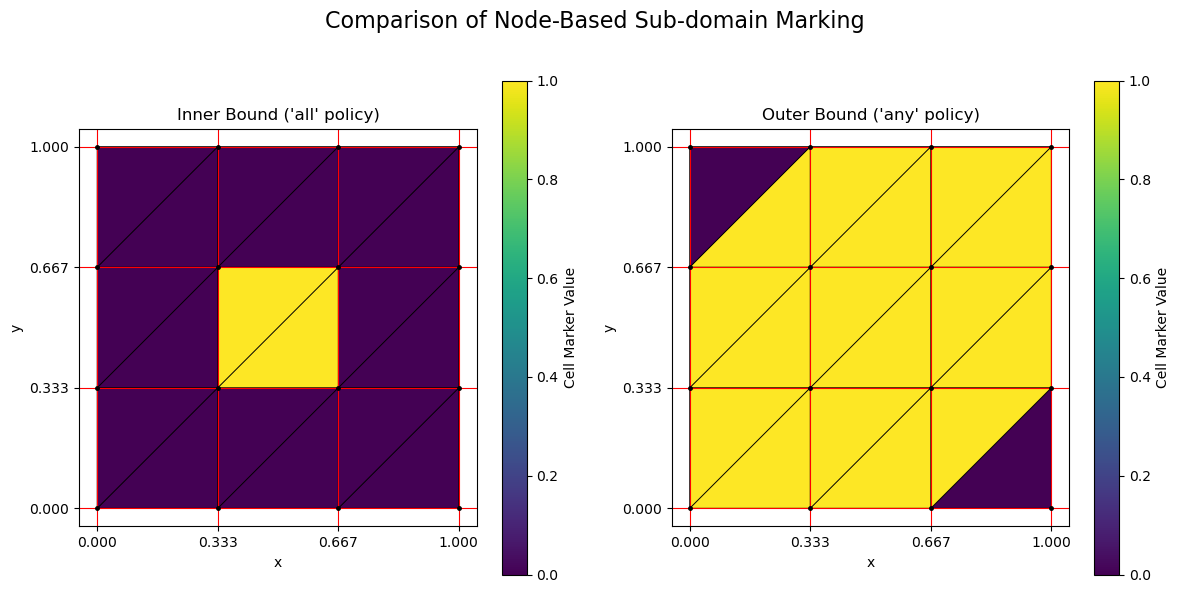

In [22]:
%matplotlib inline
num_axis = 2
plot_vals = [inner_marker, outer_marker]
subplot_titles = ["Inner Bound ('all' policy)","Outer Bound ('any' policy)"]
fig, axes = plt.subplots(1, num_axis, figsize=(12, 6))
major_locator = mticker.MultipleLocator(base=1/num_points_per_side)
for i in range(num_axis):
    plt.sca(axes[i])
    myPlot = df.plot(plot_vals[i])
    df.plot(myMesh, color='black', linewidth=0.7, marker='.', markersize=5)
    axes[i].set_title(subplot_titles[i])
    axes[i].set_xlabel("x")
    axes[i].set_ylabel("y")
    axes[i].set_aspect('equal', adjustable='box')
    axes[i].xaxis.set_major_locator(major_locator)
    axes[i].yaxis.set_major_locator(major_locator)
    axes[i].grid(True, which='major', linestyle='-', color='red')

    fig.colorbar(myPlot, ax=axes[i], label="Cell Marker Value")

# plt.sca(axes[1])
# plot_outer = df.plot(outer_marker)
# axes[1].set_title("Outer Bound ('any' policy)")
# axes[1].set_xlabel("x")
# axes[1].set_ylabel("y")
# axes[1].set_aspect('equal', adjustable='box')
# axes[1].grid(True, linestyle=':')
# fig.colorbar(plot_outer, ax=axes[1], label="Cell Marker Value")
plt.suptitle("Comparison of Node-Based Sub-domain Marking", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [23]:
V = df.FunctionSpace(myMesh, "CG", 1)

In [ ]:
M = assemble_mass_matrix(V=V, marker=inner_marker)

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


In [50]:
integrated_cov_indicator_cg1_serialized(u_list=u_1_list,
                                        u_A_list=u_2_list,\
                                        mass_matrix=M,
                                        g_constraint=0.1)

0.002222222222222226